## Import modules

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
sys.path.append("./src")

import matplotlib
import matplotlib.ticker as mtick
import itertools
import json
import dataframe_image as dfi
from PIL import Image

from importlib import reload
import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs
reload(ut)
reload(fs)

# set max display rows
pd.set_option("display.max_rows", 200)
# set max display columns
pd.set_option("display.max_columns", 100)
# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format
# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']


## Define functions

In [2]:
def create_table(df, cell_heights):
    fig, ax = plt.subplots()
    formatted_data = df.round(2).values.tolist()
    labels = df.columns.tolist()
    
    table = ax.table(cellText=formatted_data, colLabels=labels, colWidths=[.5]*len(labels), loc='center')

    cell_dict = table.get_celld()
    for i, label in enumerate(labels):
        cell_dict[(0,i)].set_height(cell_heights[0])
        for j in range(1, len(formatted_data)+1):
            cell_dict[(j,i)].set_height(cell_heights[1])

    table.set_fontsize(25)
    ax.axis('off')

    return fig, ax

def top_n(df, n=5, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True]):
    return df.sort_values(by=columns, ascending=ascending).head(n)

def get_daily_portfolio(df_rebalance, reb_lst, df_price, weight_type = 'vw', adjust_type = ["equal", "equal"],ratio: float = 0.5, weight_ratio: int = 1, rank_col: str = "rank", weight_col: str = "weight", weight_by_yields = False, replace_bottom='min'):

    df_portfolio_value_all = pd.DataFrame([])
    df_portfolio_detail_start = pd.DataFrame([])
    df_portfolio_detail_end = pd.DataFrame([])
    df_portfolio_detail_all = pd.DataFrame([])
    portfolio_quarterly_return = []
    portfolio_value = 1000000000

    for i in range(len(reb_lst) - 1):

        df_portfolio = df_rebalance.copy()

        df_portfolio_copy = df_portfolio[df_portfolio['date'] == reb_lst[i]].copy()
        df_portfolio_copy['weight'] = 1 / df_portfolio_copy.groupby('date')['ticker'].transform('count')
        df_portfolio_copy = ut.adjust_weights(df_portfolio_copy, adjust_type, ratio, weight_ratio, rank_col, weight_col)

        if weight_by_yields:
            if replace_bottom == 'min':
                df_portfolio_copy = ut.weight_by_yields(df_portfolio_copy, 5, 'adjusted_weight', 'min')
            if replace_bottom == 'q20':
                df_portfolio_copy = ut.weight_by_yields(df_portfolio_copy, 5, 'adjusted_weight', 'q20')
                
            use_weight_col = 'weight_by_yields'
        else:
            use_weight_col = 'adjusted_weight'

        df_portfolio_copy.sort_values('ticker', inplace=True)
        ticker_list = df_portfolio_copy['ticker'].unique()

        if weight_type == 'ew':
            if len(df_portfolio_value_all) == 0:
                df_portfolio_copy['portfolio_value'] = portfolio_value / len(ticker_list)
            else:
                df_portfolio_copy['portfolio_value'] = df_portfolio_value_all['portfolio_value'].iloc[-1] / len(ticker_list)

        if weight_type == 'vw':
            if len(df_portfolio_value_all) == 0:
                df_portfolio_copy['portfolio_value'] = portfolio_value * df_portfolio_copy[use_weight_col]
            else:
                df_portfolio_copy['portfolio_value'] = df_portfolio_value_all['portfolio_value'].iloc[-1] * df_portfolio_copy[use_weight_col]


        df_portfolio_copy.reset_index(drop=True, inplace=True)
        # give the weight to each stock by market cap
        # df_portfolio_copy['portfolio_value'] = df_portfolio_copy['portfolio_value'] * df_portfolio_copy['market_cap'] / df_portfolio_copy['market_cap'].sum()

        df_price_period = df_price[(df_price['ticker'].isin(ticker_list)) & (df_price['date'] >= reb_lst[i]) & (df_price['date'] <= reb_lst[i + 1])].copy()
        # check if there is price missing

        if df_price_period.groupby('ticker')['date'].count().max() != df_price_period.groupby('ticker')['date'].count().min():
            print('fuck')


        df_price_period.sort_values(['ticker','date'], inplace=True)
        df_price_period.reset_index(drop=True, inplace=True)
        df_price_period['price_shift'] = df_price_period.groupby('ticker')['price'].shift(1)
        df_price_period['rt'] = df_price_period['price'] / df_price_period['price_shift']
        df_price_period['rt'].fillna(1, inplace=True)
        # pivot the rt
        df_rt_pivot = df_price_period.pivot(index='date', columns='ticker', values='rt').copy()

        df_portfolio_value = df_rt_pivot.cumprod().mul(df_portfolio_copy['portfolio_value'].values).sum(axis=1).reset_index().rename(columns={0:'portfolio_value'})
        # print return by sub the last value by the first value
        portfolio_quarterly_return.append(df_portfolio_value['portfolio_value'].iloc[-1] / df_portfolio_value['portfolio_value'].iloc[0] - 1)

        df_portfolio_value_all = pd.concat([df_portfolio_value_all, df_portfolio_value], axis=0)

        df_portfolio_detail_start = pd.concat([df_portfolio_detail_start, pd.melt(df_rt_pivot.cumprod().mul(df_portfolio_copy['portfolio_value'].values).iloc[[0],:].reset_index(), id_vars = ['date'])], axis=0)
        df_portfolio_detail_end = pd.concat([df_portfolio_detail_end, pd.melt(df_rt_pivot.cumprod().mul(df_portfolio_copy['portfolio_value'].values).iloc[[-1],:].reset_index(), id_vars = ['date'])], axis=0)
        df_portfolio_detail_all = pd.concat([df_portfolio_detail_all, pd.melt(df_rt_pivot.cumprod().mul(df_portfolio_copy['portfolio_value'].values).reset_index(), id_vars = ['date'])], axis=0)

    df_portfolio_value_all = df_portfolio_value_all.copy()
    df_portfolio_value_all['date'] = pd.to_datetime(df_portfolio_value_all['date'])
    df_portfolio_value_all['portfolio_value'] = df_portfolio_value_all['portfolio_value'].round(0)
    df_portfolio_value_all = df_portfolio_value_all.drop_duplicates()

    return df_portfolio_value_all, df_portfolio_detail_start, df_portfolio_detail_end, df_portfolio_detail_all

def calc_sharpe_ratio(series):
    return ((series.pct_change().mean() * 252) / (series.pct_change().std() * np.sqrt(252)))

def get_rebalance_dates_by_month_day(date_list, months, day):
    # Ensure month inputs are integers and sort them
    months = sorted([int(month) for month in months])
    
    start_year = min(date_list).year
    end_year = max(date_list).year
    rebalance_dates = []
    
    for year in range(start_year, end_year + 1):
        for month in months:
            proposed_date = pd.Timestamp(year=year, month=month, day=day)
            
            # check if proposed_date is in date_list
            if proposed_date in date_list:
                rebalance_dates.append(proposed_date)
            else:
                # if not, find the next available date in date_list for that year and month
                next_available_dates = [date for date in date_list if date >= proposed_date and date.year == year]
                if next_available_dates:
                    rebalance_dates.append(next_available_dates[0])
    
    return rebalance_dates

# calc the CAGR with the last value and the first value of portfolio value
def calculate_cagr(series):
    # get the last value of portfolio value
    last_value = series.iloc[-1]
    # get the first value of portfolio value
    first_value = series.iloc[0]
    # get the total number of years
    num_years = len(series) / 252
    # calc the CAGR
    cagr = (last_value / first_value)**(1/num_years) - 1
    return cagr

In [3]:
# select model 
model_folder_name = '20230724_091431'
# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [4]:
# df_adjusted_price = pd.read_feather('data/df_adjusted_price.feather')
# df_adjusted_price.drop_duplicates(inplace=True)
# df_adjusted_price.reset_index(drop=True, inplace=True)
# df_adjusted_price_pivot = df_adjusted_price.pivot(index='年月日',columns='股票代號',values='收盤價(元)').fillna(method='ffill')
# df_adjusted_price = df_adjusted_price_pivot.reset_index().melt(id_vars='年月日', var_name='股票代號', value_name='收盤價(元)')

# # save the df_adjusted_price to feather
# df_adjusted_price.to_feather('data/quant/df_adjusted_price.feather')

# read the df_adjusted_price from feather
df_adjusted_price = pd.read_feather('data/quant/df_adjusted_price.feather')

In [5]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

df_factor_all = df_factor_all.reset_index(drop=True)
df_factor_all = deepcopy(df_factor_all)


## Liquidity Criteria

In [6]:
# df_price = pd.read_feather('data/cmoney_price.feather')
# df_price = ut.cmoney_data_clean_up(df_price)
# df_price['日期'] = pd.to_datetime(df_price['日期'])
# df_price.reset_index(drop = True).to_feather('data/quant/cmoney_price.feather')

# df_price_sub = df_price[['日期','股票代號','收盤價','成交量','成交金額(千)']].copy()
# df_price_sub.columns = ['date','ticker','close','volume','amount(k)']
# df_price_sub.sort_values(["ticker", "date"], inplace=True)
# df_price_sub.reset_index(drop=True, inplace=True)
# df_price_sub['20_d_mean_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(20).mean()['amount(k)']
# df_price_sub['252_d_mean_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(252).mean()['amount(k)']
# df_price_sub['252_d_median_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(252).median()['amount(k)']
# df_price_sub['60_d_median_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(60).median()['amount(k)']
# df_price_sub['20_d_median_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(20).median()['amount(k)']
# df_price_sub.reset_index(drop = True).to_feather('data/quant/cmoney_price_sub.feather')


# df_price_div = df_price[['日期','股票代號','收盤價']].copy()
# df_price_div.columns = ['date','ticker','unadj_price']
# df_price_div['date'] = pd.to_datetime(df_price_div['date'])
# # sort by date for shift
# df_price_div.sort_values(['ticker','date'],inplace=True)
# # shift to get last day price
# df_price_div['yesterday_price'] = df_price_div.groupby('ticker')['unadj_price'].shift(1)
# df_price_div['unadj_price'] = df_price_div['unadj_price'].astype(float)
# df_price_div['yesterday_price'] = df_price_div['yesterday_price'].astype(float)

# # df_price_div to feather
# df_price_div.reset_index(drop = True).to_feather('data/quant/cmoney_price_div.feather')

df_price = pd.read_feather('data/quant/cmoney_price.feather')
df_price_sub = pd.read_feather('data/quant/cmoney_price_sub.feather')
df_price_div = pd.read_feather('data/quant/cmoney_price_div.feather')

In [7]:
# df_price_sub_backtest = df_price_sub[['date','ticker','close']].copy()
# # change close to price
# df_price_sub_backtest.rename(columns={'close':'price'}, inplace=True)
# df_price_sub_backtest['price'] = df_price_sub_backtest['price'].astype(float)

# df_price_sub_backtest.drop_duplicates(inplace=True)
# df_price_sub_backtest.reset_index(drop=True, inplace=True)
# df_price_sub_backtest_pivot = df_price_sub_backtest.pivot(index='date',columns='ticker',values='price').fillna(method='ffill')
# df_price_sub_backtest = df_price_sub_backtest_pivot.reset_index().melt(id_vars='date', var_name='ticker', value_name='price')

# df_price_sub_backtest.to_feather('data/quant/df_price_sub_backtest.feather')
# read feather
df_price_sub_backtest = pd.read_feather('data/quant/df_price_sub_backtest.feather')

In [8]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')


reb_lst = get_rebalance_dates_by_month_day(df_factor_all[df_factor_all['date'] > '2005-02-01']['date'].unique(), [2,5,7,11], 25)

df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = reb_lst

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
# df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
factor_columns = setting['factor_columns']
df_factor_all.dropna(subset=factor_columns, inplace=True)

df_factor_all = df_factor_all.reset_index(drop=True)

df_rebalance_date = pd.DataFrame()
# df_rebalance_date['date'] = setting['rebalance_date_lst']
df_rebalance_date['date'] = reb_lst
# set date to datetime format
df_rebalance_date['date'] = pd.to_datetime(df_rebalance_date['date'])
df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='date', right_on='年月日')[['date','股票代號','收盤價(元)']].copy()

df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
df_backtest_return['price'] = df_backtest_return['price'].astype(float)
df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1

df_factor_all = df_factor_all.merge(df_backtest_return[['date','ticker','rebalance_period_return']], on=['date','ticker'], how='left')
df_factor_all_select = df_factor_all.copy()

df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [9]:
df_factor_all_reb = df_factor_all[df_factor_all['date'] == df_factor_all['rebalance_date']].copy()
df_factor_all_reb.sort_values(['date','ticker'], inplace=True)
df_factor_all_reb.reset_index(drop=True, inplace=True)
df_factor_all_reb['market_cap_billion'] = df_factor_all_reb['market_cap'] / 1000000
df_factor_all_reb['market_cap_rank'] = df_factor_all_reb.groupby('date')['market_cap'].rank(ascending=False)

In [10]:
df_factor_all_amount_rank = df_factor_all.merge(df_price_sub[['date','ticker','20_d_mean_amount_k','252_d_mean_amount_k']], on = ['date','ticker'], how = 'left')
df_factor_all_amount_rank['amount_rank_20'] = df_factor_all_amount_rank.groupby('date')['20_d_mean_amount_k'].rank(ascending=False, pct=True)
df_factor_all_amount_rank['amount_rank_20'] = df_factor_all_amount_rank.groupby('date')['20_d_mean_amount_k'].rank(ascending=False, pct=True)

# PORTFOLIO TESTING

## Backtest Params

In [43]:
38/40/2

0.475

最小檔數:  73
取得再平衡股票清單...
使用再平衡清單回測 Total Return...
績效評核 - TR...
beta: 1.00
alpha TR: 4.42%
計算 股數殖利率...
平均年化周轉率:  163.52
平均每年殖利率 7.27
計算PR殖利率...
近五年指數股息率: 
year
2018    7.0000
2019    7.7700
2020    8.5800
2021    6.8300
2022   11.4800
Name: dividend, dtype: float64
近五年指數平均股息率:  8.33
近 5 年 PR 指數累計報酬:  133.32
近 5 年 加權 PR 指數累計報酬:  [1.44223876]
近 5 年 TR 指數累計報酬:  195.98
近 5 年 加權 PR 指數累計報酬:  [1.74987709]
近 8 年 TR 指數累計報酬:  317.34
近 8 年 加權 PR 指數累計報酬:  [2.21310936]
前5檔最大總和權重 2023-03-01 00:00:00 0.318


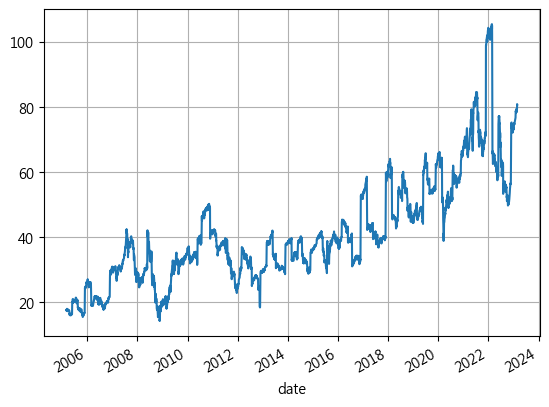

In [71]:
# ---------------------------------------------- 設定 ----------------------------------------------

CAP_TOP = 50
CAP_BOT = 200
AMOUNT_FLOOR = 40
N = 40
TURNOVER = 0
TILTED_NUM = 0.475
TILTED = 0.4
FACTOR_WEIGHT = 1
LDY_WEIGHT = 1
D1Y_WEIGHT = 1
NUM_CUT = 5
TURNOVER_DICT = {
    '2': 10,
    '3': 10,
    '5': 30,
    '7': 30,
    '11': 10,
}
WEIGHT_BY_YIELDS = False


ADJUST_WEIGHTS_PARAMS = {
   "adjust_type": ['triangle','triangle'], 
   "ratio": TILTED_NUM, 
   "weight_ratio": TILTED, 
   "rank_col": 'rank_sum_average_rank', 
   "weight_col": 'weight'
}

# ---------------------------------------------- 計算排名因子 ----------------------------------------------

df_sample_pool = df_factor_all_reb[(df_factor_all_reb["market_cap_rank"] > CAP_TOP) & (df_factor_all_reb["market_cap_rank"] <= CAP_BOT)].copy()

df_sample_pool['roe_rank'] = df_sample_pool.groupby('date')['roe'].rank(ascending=False)
df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool['20_d_return_rank'] = df_sample_pool.groupby('date')['20_d_return'].rank(ascending=False)
df_sample_pool['40_d_return_rank'] = df_sample_pool.groupby('date')['40_d_return'].rank(ascending=False)
df_sample_pool['60_d_return_rank'] = df_sample_pool.groupby('date')['60_d_return'].rank(ascending=False)
df_sample_pool['tobins_q_rank'] = df_sample_pool.groupby('date')['tobins_q'].rank(ascending=False)
df_sample_pool['roe_4q_sum_rank'] = df_sample_pool.groupby('date')['roe_4q_sum'].rank(ascending=False)
df_sample_pool['ni_yoy_rank'] = df_sample_pool.groupby('date')['ni_yoy'].rank(ascending=False)
df_sample_pool['ni_qoq_rank'] = df_sample_pool.groupby('date')['ni_qoq'].rank(ascending=False)

df_sample_pool['ni_yoy_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ni_yoy_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool['meeting_last_year_yield'] = np.where(df_sample_pool['last_dividend_yield'] == 0, df_sample_pool['dividend_1Y_sum_yield'], df_sample_pool['last_dividend_yield'])
df_sample_pool['last_dividend_yield_rank'] = df_sample_pool.groupby('date')['last_dividend_yield'].rank(ascending=False)
df_sample_pool['dividend_1Y_sum_yield_rank'] = df_sample_pool.groupby('date')['dividend_1Y_sum_yield'].rank(ascending=False)
# df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))
df_sample_pool['ocf / asset_rank'] = df_sample_pool.groupby('date')['ocf / asset'].rank(ascending=False)
df_sample_pool['ocf / asset_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ocf / asset_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool['rank_sum_1'] = df_sample_pool['roe_rank']
df_sample_pool['rank_sum_1_rank'] = df_sample_pool.groupby('date')['rank_sum_1'].rank(ascending=True)
df_sample_pool['rank_sum_1_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_1_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool['rank_sum_2'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank']
df_sample_pool['rank_sum_2_rank'] = df_sample_pool.groupby('date')['rank_sum_2'].rank(ascending=True)
df_sample_pool['rank_sum_2_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_2_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

# df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_yoy_rank'] + df_sample_pool['ni_qoq_rank']
# df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_qoq_rank']
df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_qoq_rank']
df_sample_pool['rank_sum_3_rank'] = df_sample_pool.groupby('date')['rank_sum_3'].rank(ascending=True)
df_sample_pool['rank_sum_3_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_3_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

df_sample_pool['rank_sum_average'] = df_sample_pool['rank_sum_3_rank'] * FACTOR_WEIGHT + df_sample_pool['last_dividend_yield_rank'] * LDY_WEIGHT + df_sample_pool['dividend_1Y_sum_yield_rank'] * D1Y_WEIGHT

# ---------------------------------------------- 設定流動性篩選 ----------------------------------------------

df_temp = pd.merge(df_sample_pool, df_price_sub, how="left", on=["date", "ticker"])
df_temp = pd.merge(df_temp, df_factor_all_amount_rank[['date','ticker','amount_rank_20']], how = 'left', on = ['date','ticker'])
df_temp = df_temp.dropna()

df_temp['cond1'] = df_temp['amount_rank_20'] < 0.25
df_temp['cond2'] = df_temp['20_d_mean_amount_k'] > AMOUNT_FLOOR * 1000
df_temp['cond3'] = df_temp['60_d_median_amount_k'] > AMOUNT_FLOOR * 1000
df_temp['cond4'] = df_temp['20_d_median_amount_k'] > AMOUNT_FLOOR * 1000
df_temp['cond5'] = df_temp['20_d_median_amount_k'] > AMOUNT_FLOOR * 1000
df_temp['cond6'] = df_temp['60_d_median_amount_k'] > AMOUNT_FLOOR * 1000

df_liq_pool = df_temp[(df_temp['cond5'] == True) & (df_temp['cond3'] == True) & (df_temp['cond1'] == True)].copy()
df_liq_pool_for_exist = df_temp[(df_temp['cond6'] == True) & (df_temp['cond4'] == True) & (df_temp['cond1'] == True)].copy()

print("最小檔數: ", df_liq_pool.groupby('date')['ticker'].count().min())

# ---------------------------------------------- 取得再平衡股票清單 ----------------------------------------------
print('取得再平衡股票清單...')

df_factor_all = df_factor_all.dropna(subset=['rebalance_date']).copy()
reb_lst = df_factor_all['rebalance_date'].unique()

sort_column = 'rank_sum_average'
apply_restrict_index = 0
base_portfolio_number = N
restrict_turnover = 10 / 100
remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))
# round up the restrict_portfolio_number
restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)
df_select_pool = df_liq_pool.reset_index(drop=True)
df_select_pool_for_exist = df_liq_pool_for_exist.reset_index(drop=True)
# get the base portfolio by base_portfolio_number 
df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=[sort_column], ascending=[True]).reset_index(drop=True)
# get the restrict portfolio by restrict_portfolio_number
df_select_pool_restrict = df_select_pool
df_select_pool_restrict.reset_index(drop=True, inplace=True)
df_select_pool_restrict_for_exist = df_select_pool_for_exist.reset_index(drop=True)

apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
# string format
apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')

df_restrict_result = pd.DataFrame([])
# concat the data that date is smaller than apply_restrict_date to df_restrict_result
df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
# print the max date in df_restrict_result

for i in range(apply_restrict_index, len(reb_lst)):
    # get the month of reb_lst[i]
    month = reb_lst[i].month

    apply_restrict_index = 0
    base_portfolio_number = N
    restrict_turnover = TURNOVER_DICT[str(month)] / 100
    remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))
    # round up the restrict_portfolio_number
    restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

    # get the slice data by reb_lst[i] in df_select_pool_restrict
    df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)
    df_select_pool_restrict_temp_for_exist = df_select_pool_restrict_for_exist[df_select_pool_restrict_for_exist['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

    # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
    df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_restrict_temp[['date','ticker',sort_column, 'dividend_1Y_sum_yield']].copy()
    df_new_temp['restrict'] = 1
    df_new_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
    df_new_temp.reset_index(drop=True, inplace=True)

    last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

    # df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
    df_priority_temp = df_select_pool_restrict_temp_for_exist[df_select_pool_restrict_temp_for_exist['ticker'].isin(last_portfolio_ticker_list)].copy()
    df_priority_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
    df_priority_temp.reset_index(drop=True, inplace=True)
    df_priority = df_priority_temp.head(remain_number)

    df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
    df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

    df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_restrict_result_temp to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)


df_restrict_result.reset_index(drop=True, inplace=True)
# df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()
df_restrict_result['rank_sum_average_rank'] = df_restrict_result.groupby('date')['rank_sum_average'].rank(ascending=True)

# ---------------------------------------------- 使用再平衡清單回測 - TR ----------------------------------------------
print('使用再平衡清單回測 Total Return...')

df_adjusted_price_for_backtest = df_adjusted_price.copy()
df_adjusted_price_for_backtest.columns = ['date','ticker','price']

(df_portfolio_value_all, 
 df_portfolio_value_detail_start, 
 df_portfolio_value_detail_end, 
 df_portfolio_value_detail_all
) = get_daily_portfolio(df_restrict_result, reb_lst, df_adjusted_price_for_backtest, 'vw', **ADJUST_WEIGHTS_PARAMS, weight_by_yields = WEIGHT_BY_YIELDS, replace_bottom='min')

df_compare_portfolio = df_portfolio_value_all.copy()
df_compare_portfolio.columns = ['date','portfolio_value']

# ---------------------------------------------- 績效評核 - TR ----------------------------------------------
print('績效評核 - TR...')

df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
df_benchmarks_all.columns = ['日期', 'TWA02', 'TWA00']
benchmark_list = df_benchmarks_all.columns.to_list()
benchmark_list.remove('日期')

index_name = benchmark_list[0]
df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
df_benchmarks_temp.columns = ['date',f'{index_name}']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks = df_benchmarks_temp.merge(df_compare_portfolio, on='date', how='left').dropna().copy()
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks.drop_duplicates(inplace=True)

# df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
# scale the benchmark and portfolio value to 1
df_benchmarks[f'{index_name}_scale'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
df_benchmarks['portfolio_value_scale'] = df_benchmarks['portfolio_value'] / df_benchmarks['portfolio_value'].iloc[0]

df_benchmarks.set_index('date', inplace=True)

df_benchmarks['portfolio_value_rt'] = df_benchmarks['portfolio_value_scale'].pct_change()
df_benchmarks[f'{index_name}_rt'] = df_benchmarks[f'{index_name}_scale'].pct_change()

# calculate the beta of portfolio and benchmark
beta = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
print(f'beta: {beta:.2f}')

# calculate the alpha of portfolio and benchmark
alpha = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].mean().iloc[0] - beta * df_benchmarks[f'{index_name}_rt'].mean()
# annualized the alpha
ann_alpha = (1 + alpha) ** 252 - 1
print(f'alpha TR: {ann_alpha:.2%}')

df_benchmarks['year'] = df_benchmarks.index.year
df_benchmarks['month'] = df_benchmarks.index.month
df_benchmarks['quarter'] = df_benchmarks.index.quarter

last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
df_monthly_return = pd.DataFrame(last_values / first_values)

df_monthly_return.columns = [f'{index_name}','portfolio_value_scale']
# drop the last row
df_monthly_return = df_monthly_return[:-1]
df_monthly_return['win_rate'] = np.where(df_monthly_return['portfolio_value_scale'] > df_monthly_return[f'{index_name}'], 1, 0)

df_monthly_return['portfolio_rt'] = df_monthly_return['portfolio_value_scale'].pct_change()
df_monthly_return[f'{index_name}_rt'] = df_monthly_return[f'{index_name}'].pct_change()
last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values

df_quarterly_return = pd.DataFrame(last_values / first_values)
df_quarterly_return.columns = [f'{index_name}','portfolio_value_scale']
df_quarterly_return['win_rate'] = np.where(df_quarterly_return['portfolio_value_scale'] > df_quarterly_return[f'{index_name}'], 1, 0)
last_values = df_benchmarks.groupby(['year']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
first_values  = df_benchmarks.groupby(['year']).head(1)[[f'{index_name}','portfolio_value_scale']].values
df_yearly_return = pd.DataFrame(last_values / first_values)
df_yearly_return.columns = [f'{index_name}','portfolio_value_scale']

df_yearly_return['win_rate'] = np.where(df_yearly_return['portfolio_value_scale'] > df_yearly_return[f'{index_name}'], 1, 0)
# create a list from 2005 to 2023 for year column for df_yearly_return
year_list = list(range(2005,2024))
df_yearly_return['year'] = year_list

df_yearly_return[['portfolio_value_scale',f'{index_name}']] = df_yearly_return[['portfolio_value_scale',f'{index_name}']] - 1

df_benchmarks_temp.reset_index(inplace=True, drop=True)
df_benchmarks_temp.set_index('date', inplace=True)


# series_cagr = calculate_cagr(df_benchmarks[df_benchmarks.index > '2007-06-21'])[:3]
series_cagr = calculate_cagr(df_benchmarks)[:2]
series_sr = calc_sharpe_ratio(df_benchmarks)[:2]


# ---------------------------------------------- 計算 股數殖利率 ----------------------------------------------
print('計算 股數殖利率...')

select_ticker = df_restrict_result['ticker'].unique()
df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
df_cash_dividends.columns = ['ticker','date','dividend']
df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
df_cash_dividends.drop_duplicates(inplace=True)
df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

df_factor_all_price = pd.merge(df_factor_all_select,df_price_div,on=['date','ticker'],how='left')
df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

# calculate the sum of dividend yield of each stock in each period 
df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')

# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

turnover_ratio_lst =  []

for i in range(1, len(reb_lst) - 1):
    df_start_temp = df_portfolio_value_detail_start[df_portfolio_value_detail_start['date'].isin([reb_lst[i]])]
    df_end_temp = df_portfolio_value_detail_end[df_portfolio_value_detail_end['date'].isin([reb_lst[i]])]
    df_rebalance_temp = pd.merge(df_start_temp, df_end_temp, on=['date','ticker'], how='outer', suffixes=('_start', '_end')).fillna(0)
    df_rebalance_temp['turnover'] = abs(df_rebalance_temp['value_end'] - df_rebalance_temp['value_start'])
    turnover_ratio = (df_rebalance_temp['turnover'].sum() / df_start_temp['value'].sum()) / 2 * 100
    turnover_ratio_lst.append(turnover_ratio)

# create a dataframe to store the turnover ratio with the rebalance date
df_quarterly_turnover = pd.DataFrame({'date': reb_lst[1:-1], 'turnover': turnover_ratio_lst}).dropna()

df_quarterly_turnover['year'] = df_quarterly_turnover['date'].dt.year
df_quarterly_turnover['quarter'] = df_quarterly_turnover['date'].dt.quarter
df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()

print("平均年化周轉率: ", df_yearly_turnover['turnover'].mean().round(2))
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_turnover = df_yearly_turnover['turnover'].describe().reset_index()
df_turnover.columns = ['index_name', '一般版']

df_dividend_select_yield_test = df_dividend_select_yield.copy()
df_dividend_select_yield_test = ut.adjust_weights(df_dividend_select_yield_test, **ADJUST_WEIGHTS_PARAMS)

if WEIGHT_BY_YIELDS:
    df_dividend_select_yield_test = ut.weight_by_yields(df_dividend_select_yield_test, 5, 'adjusted_weight')
    use_weight = 'weight_by_yields'
else:
    use_weight = 'adjusted_weight'


df_dividend_select_yield_test['weighted_yield'] = df_dividend_select_yield_test['unadj_yield'] * df_dividend_select_yield_test[use_weight]

df_weighted_dividends = df_dividend_select_yield_test[df_dividend_select_yield_test['weighted_yield'] > 0] [['date','ticker', use_weight,'weighted_yield']].copy()

df_quarterly_div = df_dividend_select_yield_test.groupby('date')['weighted_yield'].sum().reset_index()
df_quarterly_div['year'] = df_quarterly_div['date'].dt.year
print("平均每年殖利率", round(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean().round(4) * 100, 2))


# ---------------------------------------------- 計算PR殖利率 ----------------------------------------------
print('計算PR殖利率...')

df_reb_map = pd.DataFrame([])
df_reb_map['date'] = df_portfolio_value_detail_start['date'].unique()
df_reb_map['date_end'] = df_portfolio_value_detail_end['date'].unique()

df_dividends_value = pd.merge(df_weighted_dividends, df_benchmarks.reset_index()[['date','portfolio_value']])
df_dividends_value['dividends_value'] = df_dividends_value['portfolio_value'] * df_dividends_value['weighted_yield']

df_dividends_adjustment = pd.merge(df_portfolio_value_detail_start, df_dividends_value[['date','ticker','dividends_value']], how = 'left', on = ['date','ticker']).fillna(0)
total_value = df_dividends_adjustment.groupby('date')['value'].transform('sum')
df_dividends_adjustment['weight'] = df_dividends_adjustment['value'] / total_value
df_dividends_adjustment = pd.merge(df_dividends_adjustment, df_reb_map, on='date')
df_dividends_adjustment = pd.merge(df_dividends_adjustment, df_portfolio_value_detail_end, how = 'left', left_on = ['date_end','ticker'], right_on = ['date','ticker']).fillna(0)
# Compute the total value for each date

# Compute the weight of each ticker by dividing its value by the total value for its date
df_dividends_adjustment['last_value_ex_div'] = df_dividends_adjustment['value_y'] - df_dividends_adjustment['dividends_value']
df_dividends_adjustment['price_return'] = (df_dividends_adjustment['last_value_ex_div'] / df_dividends_adjustment['value_x'] - 1) * df_dividends_adjustment['weight']
df_dividends_adjustment['total_return'] = (df_dividends_adjustment['value_y'] / df_dividends_adjustment['value_x'] - 1) * df_dividends_adjustment['weight']
df_tr_pr = pd.merge(df_dividends_adjustment.groupby(['date_x'])['total_return'].sum().reset_index(), df_dividends_adjustment.groupby(['date_x'])['price_return'].sum(), on = 'date_x')
# change column name date_x to date
df_tr_pr = df_tr_pr.rename(columns={'date_x':'date'})

# add 1 to the return
df_tr_pr['total_return'] = df_tr_pr['total_return'] + 1
df_tr_pr['price_return'] = df_tr_pr['price_return'] + 1

# subtract year from date
df_tr_pr['year'] = df_tr_pr['date'].dt.year

# group by year and multiply the returns
df_tr_year = df_tr_pr.groupby('year')['total_return'].prod().reset_index()
df_pr_year = df_tr_pr.groupby('year')['price_return'].prod().reset_index()

# merge the two dataframes
df_tr_pr_year = pd.merge(df_tr_year, df_pr_year, on = 'year')
df_tr_pr_year['dividend'] = df_tr_pr_year['total_return'] - df_tr_pr_year['price_return']
df_tr_pr_year.index = df_tr_year['year']

df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
df_benchmarks_all.columns = ['日期', 'TWA02', 'TWA00']

print("近五年指數股息率: ")
print(round(df_tr_pr_year['dividend'].tail(5) * 100, 2))
print("近五年指數平均股息率: ", round(df_tr_pr_year['dividend'].tail(5).mean() * 100, 2))
print("近 5 年 PR 指數累計報酬: ", round(df_tr_pr_year['price_return'].tail(5).prod() * 100, 2))
print("近 5 年 加權 PR 指數累計報酬: ", df_benchmarks_all[df_benchmarks_all['日期'] == '2023/03/01']['TWA00'].values / df_benchmarks_all[df_benchmarks_all['日期'] == '2018/02/27']['TWA00'].values)
print("近 5 年 TR 指數累計報酬: ", round(df_tr_pr_year['total_return'].tail(5).prod() * 100, 2))
print("近 5 年 加權 PR 指數累計報酬: ", df_benchmarks_all[df_benchmarks_all['日期'] == '2023/03/01']['TWA02'].values / df_benchmarks_all[df_benchmarks_all['日期'] == '2018/02/27']['TWA02'].values)
print("近 8 年 TR 指數累計報酬: ", round(df_tr_pr_year['total_return'].tail(8).prod() * 100, 2))
print("近 8 年 加權 PR 指數累計報酬: ", df_benchmarks_all[df_benchmarks_all['日期'] == '2023/03/01']['TWA02'].values / df_benchmarks_all[df_benchmarks_all['日期'] == '2015/02/26']['TWA02'].values)



df_quarterly_div['year'] = df_quarterly_div['date'].dt.year

mean_div = round(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean() * 100, 2)



df_weight_detail = df_portfolio_value_detail_all.sort_values(['date','ticker']).reset_index(drop=True).copy()

# Compute the total value for each date
total_value = df_weight_detail.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value for its date
df_weight_detail['weight'] = df_weight_detail['value'] / total_value

df_top_5_weighting = df_weight_detail.sort_values(['date','weight'], ascending = False).groupby('date').head(5).copy()
df_top_5_weighting = df_top_5_weighting.groupby('date')['weight'].sum().reset_index()
print("前5檔最大總和權重",df_top_5_weighting.max()['date'], round(df_top_5_weighting.max()['weight'], 4))

df_market_cap_copy = df_factor_all[['date','ticker','market_cap']].copy()

df_weight_detail = pd.merge(df_weight_detail, df_market_cap_copy, on = ['date','ticker'], how = 'left').copy()

df_weight_detail['max_aum_assumption'] = df_weight_detail['market_cap'] * 0.1 / df_weight_detail['weight'] / 1000000
df_weight_detail[df_weight_detail['date'].isin(reb_lst) == False].groupby('date')['max_aum_assumption'].min().plot()

plt.grid()

df_df_weight_detail_min = df_weight_detail[df_weight_detail['date'].isin(reb_lst) == False].groupby('date')['max_aum_assumption'].min().reset_index()

df_normal_day = df_portfolio_value_detail_all[df_portfolio_value_detail_all['date'].isin(reb_lst) == False].sort_values(['date','ticker']).reset_index(drop = True).copy()
df_normal_day = df_normal_day[df_normal_day['date'] > '2018-01-01']
# Compute the total value for each date
total_value = df_normal_day.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value for its date
df_normal_day['weight'] = df_normal_day['value'] / total_value
df_amount = df_price[['日期','股票代號','成交金額(千)']]
df_amount.columns = ['date','ticker','amount']

df_normal_day = pd.merge(df_normal_day, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_normal_day['amount'] = df_normal_day['amount'].astype(int)
df_normal_day = df_normal_day[df_normal_day['amount'] != 0]
df_normal_day['amount_assumption'] = df_normal_day['amount'] * 0.5 / df_normal_day['weight']
df_normal_day.sort_values(['date','amount_assumption'], inplace=True)
df_normal_day = df_normal_day.merge(df_factor_all_amount_rank[['date','ticker','amount_rank_20']], how='left', on=['date','ticker'])
df_normal_day.groupby('date')['amount_assumption'].min().mean()


# save the params and result to a dictionary
result_dict = {
    'CAP_TOP': CAP_TOP,
    'CAP_BOT': CAP_BOT,
    'AMOUNT_FLOOR': AMOUNT_FLOOR,
    'N': N,
    'TILTED_NUM': TILTED_NUM,
    'TILTED': TILTED,
    'LDY_WEIGHT': LDY_WEIGHT,
    'D1Y_WEIGHT': D1Y_WEIGHT,
    'WEIGHT_BY_YIELDS': WEIGHT_BY_YIELDS,
    'SR_BENCH': round(series_sr[0], 2),
    'SR_PORT': round(series_sr[1], 2),
    'CAGR_BENCH': round(series_cagr[0], 4),
    'CAGR_PORT': round(series_cagr[1], 4),
    'ALPHA': round(ann_alpha, 4),
    'BETA': round(beta, 4),
    'MEAN_DIV': round(mean_div, 4),
    'TURNOVER(%)': round(df_turnover[df_turnover['index_name'] == 'mean']['一般版'].values[0], 2),
    'PR_DIV_5Y': round(df_tr_pr_year['dividend'].tail(5).mean() * 100, 2),
    'PR_DIV_ALL': round(df_tr_pr_year['dividend'].mean() * 100, 2),
    'CUM_PR_PORT_5Y': round(df_tr_pr_year['price_return'].tail(5).prod() * 100, 2),
    'CUM_PR_PORT_8Y': round(df_tr_pr_year['price_return'].prod() * 100, 2),
    'CUM_TR_PORT_5Y': round(df_tr_pr_year['total_return'].tail(5).prod() * 100, 2),
    'CUM_TR_PORT_8Y': round(df_tr_pr_year['total_return'].prod() * 100, 2),
    'TOP_5_WEIGHTING': round(df_top_5_weighting.max()['weight'], 4),
    'MIN_AUM_ASSUMPTION': df_df_weight_detail_min[df_df_weight_detail_min['date'] > '2018-01-01'].min()['max_aum_assumption'],
    'MIN_AMOUNT_ASSUMPTION_MEAN': df_normal_day.groupby('date')['amount_assumption'].min().mean(),
    'MIN_AMOUNT_ASSUMPTION_MIN': df_normal_day.groupby('date')['amount_assumption'].min().min(),
}


# plt.savefig(f'./figs/{params_str}_max_aum_assumption.png', dpi=300)

# pd.DataFrame([params_dict]).iloc[:,:5].dfi.export(f'./figs/table_{params_str}_1.png')
# pd.DataFrame([params_dict]).iloc[:,6:10].dfi.export(f'./figs/table_{params_str}_2.png')
# pd.DataFrame([params_dict]).iloc[:,10:14].dfi.export(f'./figs/table_{params_str}_3.png')
# pd.DataFrame([params_dict]).iloc[:,14:].dfi.export(f'./figs/table_{params_str}_4.png')

# # loop the f'./figs/table_{params_str}_1.png' to 4
# for i in range(1, 5):
#     ut.crop_index(f'./figs/table_{params_str}_{i}.png')

# ut.merge_images([f'./figs/table_{params_str}_{i}.png' for i in range(1, 5)], f'./figs/{params_str}_table.png', 10)

# # delete all the f'./figs/table_{params_str}_{i}.png'
# for i in range(1, 5):
#     os.remove(f'./figs/table_{params_str}_{i}.png')

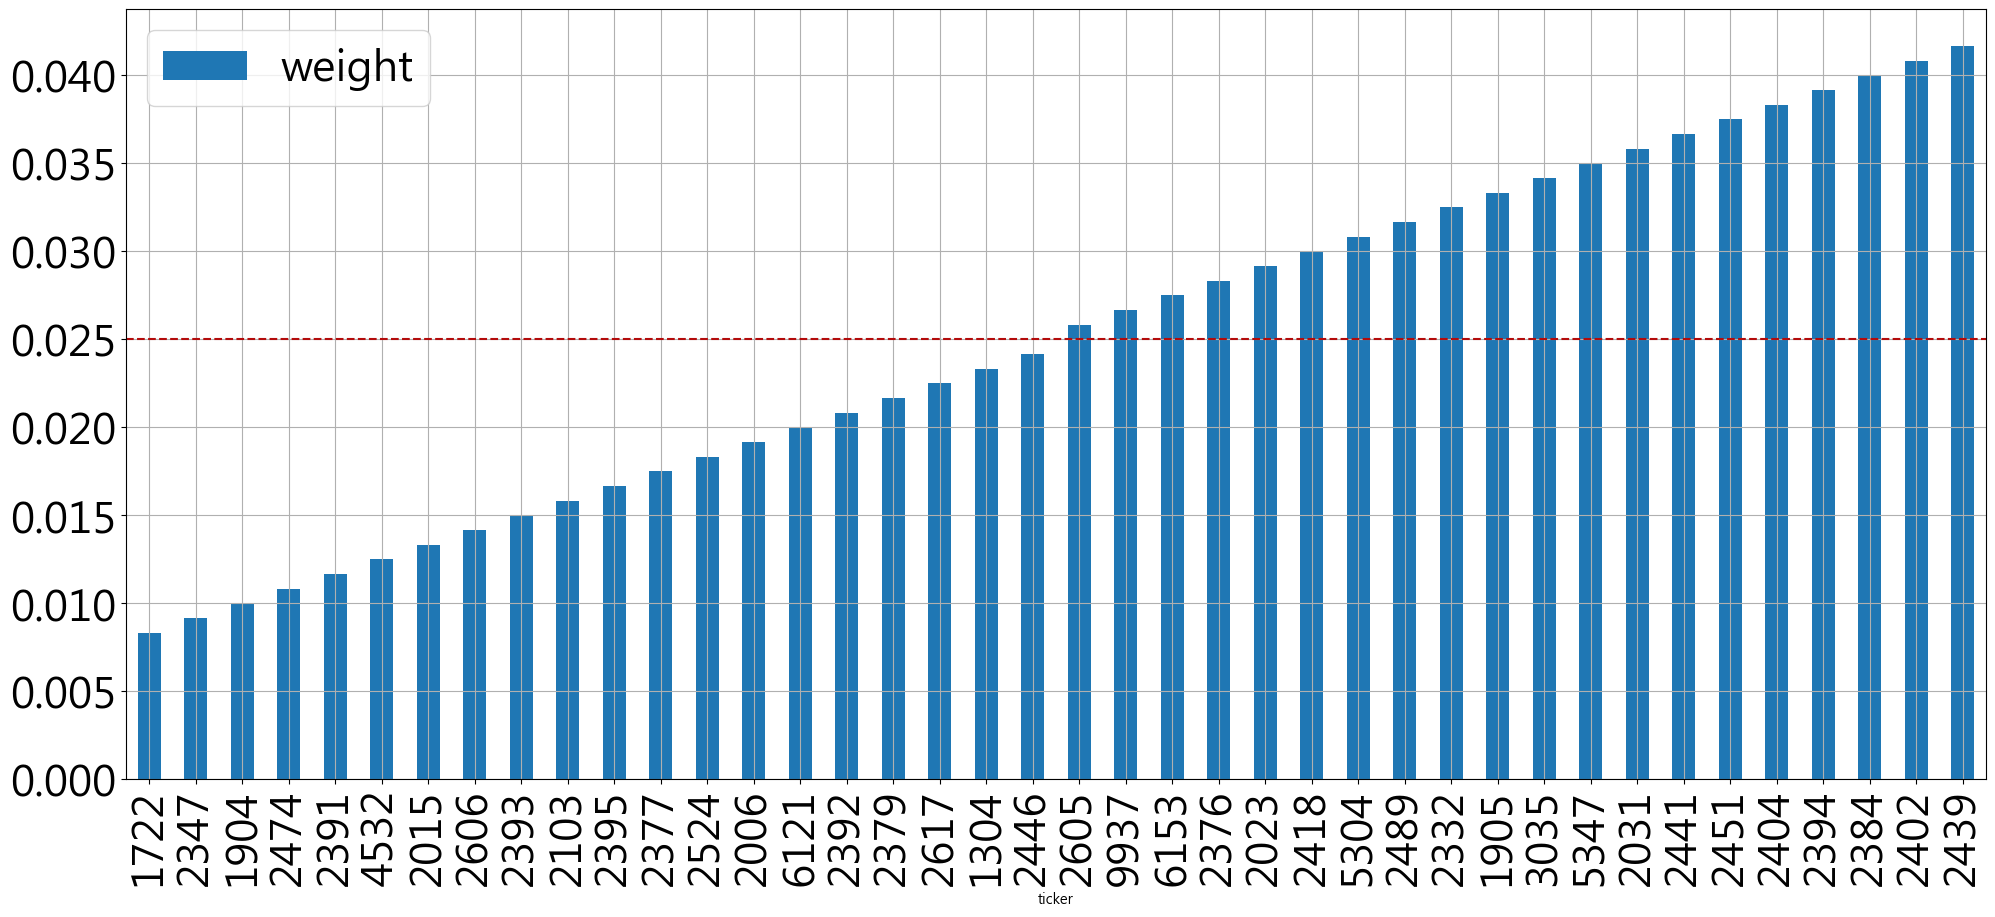

In [66]:
# 排序分數加權權重範例

df_single_day_weight = df_weight_detail[df_weight_detail['date'].isin([reb_lst[0]])].sort_values(by=['weight'])
# plot the df_single_day_weight by weight with bar
df_single_day_weight.plot.bar(x='ticker', y='weight', figsize=(24, 10), fontsize=30, rot=90)
plt.grid()

# plot a horizontal line at 0.025 with dashed line style
plt.axhline(y=0.025, color='#b30b0b', linestyle='dashed')

# change the font size of legend
plt.legend(fontsize=30)

In [49]:
pd.DataFrame([result_dict])

,CAP_TOP,CAP_BOT,AMOUNT_FLOOR,N,TILTED_NUM,TILTED,LDY_WEIGHT,D1Y_WEIGHT,WEIGHT_BY_YIELDS,SR_BENCH,SR_PORT,CAGR_BENCH,CAGR_PORT,ALPHA,BETA,MEAN_DIV,TURNOVER(%),PR_DIV_5Y,PR_DIV_ALL,CUM_PR_PORT_5Y,CUM_PR_PORT_8Y,CUM_TR_PORT_5Y,CUM_TR_PORT_8Y,TOP_5_WEIGHTING,MIN_AUM_ASSUMPTION,MIN_AMOUNT_ASSUMPTION_MEAN,MIN_AMOUNT_ASSUMPTION_MIN
0,50,200,40,40,0.4750,0.3500,1,1,False,0.5900,0.7100,0.0950,0.1349,0.0418,1.0019,7.1200,155.0900,8.1500,8.0500,133.3900,233.8500,194.5400,929.7700,0.3044,40.8656,772807.9845,137440.8330


In [68]:
df_tt = df_portfolio_value_detail_start[df_portfolio_value_detail_start['date'].isin(reb_lst)].groupby('date')['ticker'].count().reset_index()
print(len(df_tt[df_tt['ticker'] <= 39]))

0


## Stocks Numbers Turnover

In [69]:
# merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')
# create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

df_weight = pd.pivot(df_dividend_select_yield, index='rebalance_date', columns='ticker', values='weight').copy()
df_weight.fillna(0,inplace=True)

# calculate the turnover by calculate the abs change of weight and sum up
df_weight_change = df_weight.diff().abs() / 2 * 100
df_quarterly_turnover = df_weight_change.sum(axis=1).reset_index()
df_quarterly_turnover.columns = ['rebalance_date','turnover']

df_quarterly_turnover['year'] = df_quarterly_turnover['rebalance_date'].dt.year
df_quarterly_turnover['quarter'] = df_quarterly_turnover['rebalance_date'].dt.quarter
df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()
# df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
df_yearly_turnover['turnover'].describe().reset_index()


,index,turnover
0,count,18.0000
1,mean,93.4722
2,std,10.0783
3,min,77.5000
4,25%,87.5000
5,50%,91.2500
6,75%,100.0000
7,max,115.0000


In [70]:
df_yearly_turnover

,year,turnover
0,2005,77.5000
1,2006,82.5000
2,2007,100.0000
3,2008,100.0000
4,2009,90.0000
5,2010,95.0000
6,2011,115.0000
7,2012,100.0000
8,2013,87.5000
9,2014,100.0000


In [53]:
# df_temp = df_quarterly_turnover[['date','turnover']].plot(kind='bar', x='date', y='turnover', figsize=(20, 10))
# plt.grid()

## Test for Capabilities for Market Capital

In [54]:
df_normal_day = df_portfolio_value_detail_all[df_portfolio_value_detail_all['date'].isin(reb_lst) == False].sort_values(['date','ticker']).reset_index(drop = True).copy()
df_normal_day = df_normal_day[df_normal_day['date'] > '2018-01-01']
# Compute the total value for each date
total_value = df_normal_day.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value for its date
df_normal_day['weight'] = df_normal_day['value'] / total_value
df_amount = df_price[['日期','股票代號','成交金額(千)']]
df_amount.columns = ['date','ticker','amount']

df_normal_day = pd.merge(df_normal_day, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_normal_day['amount'] = df_normal_day['amount'].astype(int)
df_normal_day = df_normal_day[df_normal_day['amount'] != 0]
df_normal_day['amount_assumption'] = df_normal_day['amount'] * 0.5 / df_normal_day['weight']
df_normal_day.sort_values(['date','amount_assumption'], inplace=True)
df_normal_day = df_normal_day.merge(df_factor_all_amount_rank[['date','ticker','amount_rank_20']], how='left', on=['date','ticker'])
df_normal_day.groupby('date')['amount_assumption'].min().describe()

count      1235.0000
mean     772807.9845
std      465268.7552
min      137440.8330
25%      448582.8369
50%      660985.1552
75%      963758.0741
max     4166155.7769
Name: amount_assumption, dtype: float64

## Plot Portfolio Value

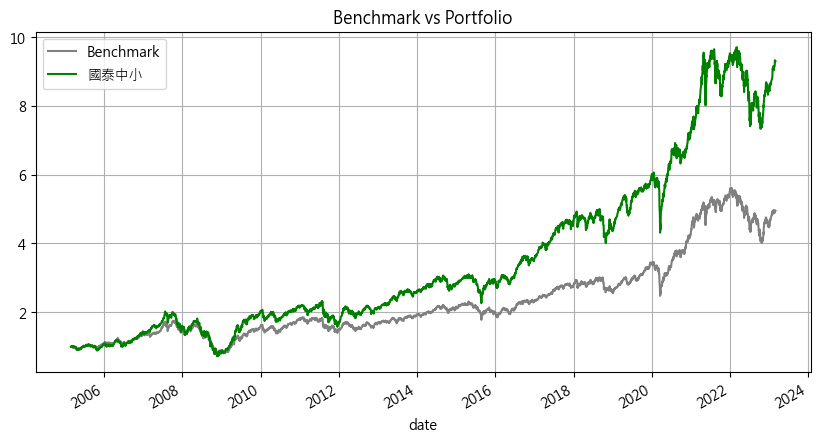

In [55]:
df_benchmarks.plot(y = ['TWA02_scale','portfolio_value_scale'], label = ['Benchmark','國泰中小'], figsize = (10, 5), title = 'Benchmark vs Portfolio', color = ['gray',"green"])
plt.grid()

## Plot Yearly Win Rate

beta: 1.00
alpha TR: 4.18%


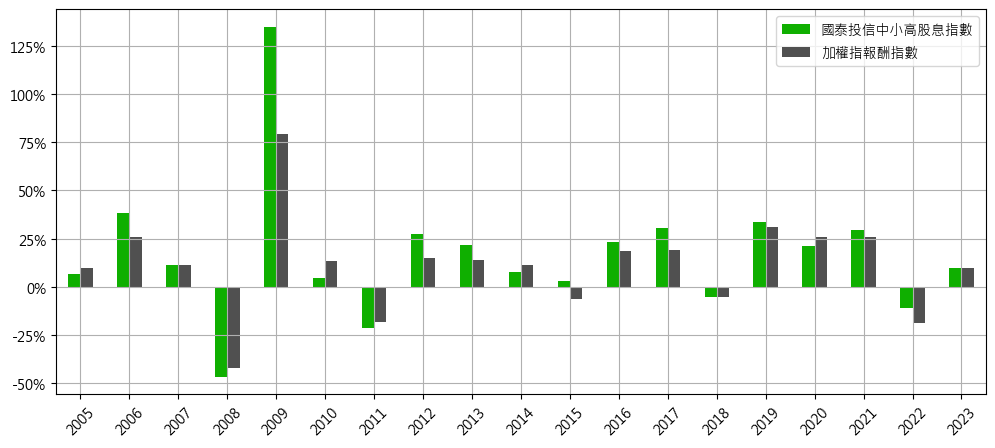

In [56]:
df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
df_benchmarks_all.columns = ['日期', 'TWA02', 'TWA00']
benchmark_list = df_benchmarks_all.columns.to_list()
benchmark_list.remove('日期')

index_name = benchmark_list[0]
df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
df_benchmarks_temp.columns = ['date',f'{index_name}']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks = df_benchmarks_temp.merge(df_compare_portfolio, on='date', how='left').dropna().copy()
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks.drop_duplicates(inplace=True)

# df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
# scale the benchmark and portfolio value to 1
df_benchmarks[f'{index_name}_scale'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
df_benchmarks['portfolio_value_scale'] = df_benchmarks['portfolio_value'] / df_benchmarks['portfolio_value'].iloc[0]

df_benchmarks.set_index('date', inplace=True)

df_benchmarks['portfolio_value_rt'] = df_benchmarks['portfolio_value_scale'].pct_change()
df_benchmarks[f'{index_name}_rt'] = df_benchmarks[f'{index_name}_scale'].pct_change()

# calculate the beta of portfolio and benchmark
beta = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
print(f'beta: {beta:.2f}')

# calculate the alpha of portfolio and benchmark
alpha = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].mean().iloc[0] - beta * df_benchmarks[f'{index_name}_rt'].mean()
# annualized the alpha
ann_alpha = (1 + alpha) ** 252 - 1
print(f'alpha TR: {ann_alpha:.2%}')

df_benchmarks['year'] = df_benchmarks.index.year
df_benchmarks['month'] = df_benchmarks.index.month
df_benchmarks['quarter'] = df_benchmarks.index.quarter

last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values

last_values = df_benchmarks.groupby(['year']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
first_values  = df_benchmarks.groupby(['year']).head(1)[[f'{index_name}','portfolio_value_scale']].values
df_yearly_return = pd.DataFrame(last_values / first_values)
df_yearly_return.columns = [f'{index_name}','portfolio_value_scale']
# drop the last row
# df_yearly_return = df_yearly_return[:-1]
df_yearly_return['win_rate'] = np.where(df_yearly_return['portfolio_value_scale'] > df_yearly_return[f'{index_name}'], 1, 0)
# create a list from 2005 to 2023 for year column for df_yearly_return
year_list = list(range(2005,2024))
df_yearly_return['year'] = year_list
df_yearly_return[['portfolio_value_scale',f'{index_name}']] = df_yearly_return[['portfolio_value_scale',f'{index_name}']] - 1

# plot the return of portfolio and benchmark with bar chart
df_yearly_return[['portfolio_value_scale',f'{index_name}']].plot.bar(figsize=(12,5), color=['#0faf00ff','#505050ff'])


import matplotlib.ticker as mtick
# set font with Arial
matplotlib.rcParams['font.family'] = 'Arial'

# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.family'] = ['Microsoft JhengHei']

# set the x axis with column year
plt.xticks(df_yearly_return.index, df_yearly_return['year'])

plt.rcParams['axes.unicode_minus'] = False
# rotate the x axis 45 degree
plt.xticks(rotation=45)

# format the yticks with % without other module
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(['國泰投信中小高股息指數', '加權指報酬指數'])
plt.grid()
# plt.savefig(f'./figs/{model_folder_name}/{file_name_prefix}_ann_return.png', bbox_inches='tight')

In [57]:
df_quarterly_div.groupby('year')['weighted_yield'].sum().describe()

count   18.0000
mean     0.0712
std      0.0152
min      0.0553
25%      0.0623
50%      0.0669
75%      0.0726
max      0.1145
Name: weighted_yield, dtype: float64

## Plot Yearly Dividends Yield

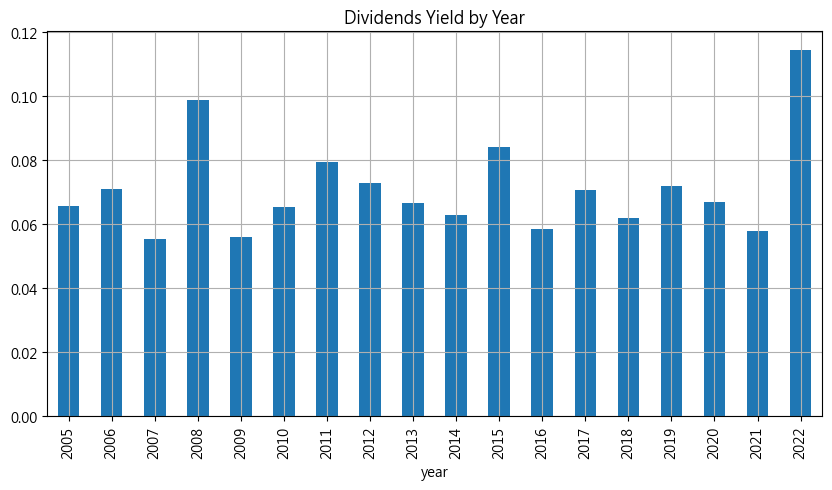

In [58]:
df_quarterly_div.groupby('year')['weighted_yield'].sum().plot(kind='bar', figsize=(10, 5))
plt.title('Dividends Yield by Year')
plt.grid()

In [59]:
import re


def get_trading_window(trading_days, quarterly_dates, direction='both'):
    """
    Get 5 trading days before and/or after each date in quarterly_dates that exists in trading_days.

    Parameters:
    - trading_days (list): List of trading dates
    - quarterly_dates (list): List of quarterly dates
    - direction (str): 'before', 'after', or 'both' (default is 'both')

    Returns:
    - dict: A dictionary where key is the date from quarterly_dates and value is a list of 5 trading days before and/or after.
    """
    
    # result = {}
    result = []
    
    for q_date in quarterly_dates:
        if q_date in trading_days:
            index = trading_days.index(q_date)
            
            before_window = trading_days[max(0, index-5):index] if index >= 5 else trading_days[0:index]
            after_window = trading_days[index+1:index+6] if index+6 <= len(trading_days) else trading_days[index+1:]
            
            if direction == 'before':
                # result[q_date] = before_window
                result.append(before_window)

            elif direction == 'after':
                # result[q_date] = after_window
                result.append(after_window)
            else:
                # result[q_date] = (before_window, after_window)
                result.append(before_window)
                result.append(after_window)
                # result[q_date] = (before_window, after_window)
    
    return result


In [60]:
date_before_reb = get_trading_window(df_portfolio_value_detail_all['date'].unique().tolist(), reb_lst, 'before')
# flatten the list
date_before_reb = [item for sublist in date_before_reb for item in sublist]

df_rebalance_days_before = df_portfolio_value_detail_all[df_portfolio_value_detail_all['date'].isin(date_before_reb)].sort_values(['date','ticker']).reset_index(drop = True).copy()
df_rebalance_days_before = df_rebalance_days_before[df_rebalance_days_before['date'] > '2018-01-01']
# Compute the total value for each date
total_value = df_rebalance_days_before.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value fJor its date
df_rebalance_days_before['weight'] = df_rebalance_days_before['value'] / total_value
df_amount = df_price[['日期','股票代號','成交金額(千)']]
df_amount.columns = ['date','ticker','amount']

df_rebalance_days_before = pd.merge(df_rebalance_days_before, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_rebalance_days_before['amount'] = df_rebalance_days_before['amount'].astype(int)
df_rebalance_days_before = df_rebalance_days_before[df_rebalance_days_before['amount'] != 0]

df_rebalance_days_before['reb_amount'] = 20000000 * df_rebalance_days_before['weight'] / 5
df_rebalance_days_before['ratio_assumption'] = df_rebalance_days_before['reb_amount'] / df_rebalance_days_before['amount'] 
df_rebalance_days_before.sort_values(['date','ratio_assumption'], inplace=True)

df_rebalance_days_before.groupby('date')['ratio_assumption'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2018-02-09,40.0000,0.8248,0.8429,0.0764,0.2070,0.5199,1.2535,4.2938
2018-02-12,40.0000,1.0488,0.9965,0.1188,0.2822,0.7396,1.5952,3.9420
2018-02-21,40.0000,0.8403,0.8674,0.0495,0.2251,0.5056,1.2941,3.8749
2018-02-22,40.0000,1.1484,1.1842,0.0807,0.2341,0.7238,1.9125,5.0619
2018-02-23,40.0000,0.9416,0.9575,0.0539,0.2745,0.4570,1.4967,3.1052
2018-05-18,40.0000,1.0527,1.2285,0.0433,0.3143,0.6193,1.3124,6.3677
2018-05-21,40.0000,1.1230,1.6213,0.0363,0.1930,0.5158,1.3850,8.1749
2018-05-22,40.0000,0.9859,1.0039,0.0236,0.2544,0.6729,1.3866,3.7466
2018-05-23,40.0000,1.1926,1.3676,0.0269,0.2751,0.6358,1.5267,5.5878


In [61]:
date_after_reb = get_trading_window(df_portfolio_value_detail_all['date'].unique().tolist(), reb_lst, 'after')
# flatten the list
date_after_reb = [item for sublist in date_after_reb for item in sublist]

df_rebalance_days_after = df_portfolio_value_detail_all[df_portfolio_value_detail_all['date'].isin(date_after_reb)].sort_values(['date','ticker']).reset_index(drop = True).copy()
df_rebalance_days_after = df_rebalance_days_after[df_rebalance_days_after['date'] > '2018-01-01']
# Compute the total value for each date
total_value = df_rebalance_days_after.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value fJor its date
df_rebalance_days_after['weight'] = df_rebalance_days_after['value'] / total_value
df_amount = df_price[['日期','股票代號','成交金額(千)']]
df_amount.columns = ['date','ticker','amount']

df_rebalance_days_after = pd.merge(df_rebalance_days_after, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_rebalance_days_after['amount'] = df_rebalance_days_after['amount'].astype(int)
df_rebalance_days_after = df_rebalance_days_after[df_rebalance_days_after['amount'] != 0]

df_rebalance_days_after['reb_amount'] = 40000000 * df_rebalance_days_after['weight'] / 5
df_rebalance_days_after['ratio_assumption'] = df_rebalance_days_after['reb_amount'] / df_rebalance_days_after['amount'] 
df_rebalance_days_after.sort_values(['date','ratio_assumption'], inplace=True)

df_rebalance_days_after.groupby('date')['ratio_assumption'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2018-02-27,40.0000,1.9197,2.2443,0.1323,0.4576,0.8294,2.5302,8.1627
2018-03-01,40.0000,1.8041,2.4239,0.0941,0.4095,0.9075,1.8419,9.9109
2018-03-02,40.0000,2.0922,3.0705,0.1276,0.4561,0.9370,2.6638,17.1515
2018-03-05,40.0000,1.9282,2.1226,0.1521,0.5123,0.9732,2.5947,9.5972
2018-03-06,40.0000,2.6305,3.1727,0.1431,0.5735,1.2295,2.7863,12.1627
2018-05-28,40.0000,2.0748,1.8532,0.2081,0.6890,1.5800,2.9040,8.4078
2018-05-29,40.0000,2.3579,2.2271,0.0824,1.0721,1.9399,2.6712,10.9900
2018-05-30,40.0000,1.5037,0.8877,0.1582,0.8199,1.5018,2.0798,3.5275
2018-05-31,40.0000,1.2810,1.0979,0.1814,0.6234,0.9638,1.6445,4.7689


## Test for capability

In [62]:
df_factor_liq_test = df_factor_all.copy()
df_factor_liq_test['market_cap_rank'] = df_factor_liq_test.groupby('date')['market_cap'].rank(ascending=False)
df_factor_liq_test = df_factor_liq_test[df_factor_liq_test['market_cap_rank'] <= 50]
df_factor_liq_test['weight'] = 0.025
df_factor_liq_test = pd.merge(df_factor_liq_test, df_amount, how='left', on=['date', 'ticker']).dropna().reset_index(drop = True)
df_factor_liq_test['amount'] = df_factor_liq_test['amount'].astype(int)

df_factor_liq_test['reb_amount'] = 40000000 * df_factor_liq_test['weight'] / 5
df_factor_liq_test['ratio_assumption'] = df_factor_liq_test['reb_amount'] / df_factor_liq_test['amount'] 
df_factor_liq_test.sort_values(['date','ratio_assumption'], inplace=True)
df_factor_liq_test = df_factor_liq_test[['date','ticker','ratio_assumption']]
df_factor_liq_test = df_factor_liq_test[df_factor_liq_test['date'] >= '2018-01-01']
# df_factor_liq_test = df_factor_liq_test.merge(df_price_sub[['date','ticker','20_d_mean_amount_k','252_d_mean_amount_k']], on = ['date','ticker'], how = 'left')
df_factor_liq_test.groupby('date')['ratio_assumption'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2018-02-26,48.0000,1.3169,2.7974,0.0224,0.2325,0.4658,1.1024,15.4847
2018-05-25,50.0000,1.3196,2.7941,0.0216,0.2124,0.4999,1.1887,17.5469
2018-07-25,50.0000,4.8391,22.7811,0.0239,0.1699,0.4713,0.9133,156.9859
2018-11-26,50.0000,3.5602,12.8361,0.0255,0.3242,0.6812,1.1516,81.6993
2019-02-25,50.0000,0.7627,1.2435,0.0334,0.2511,0.4721,0.8168,8.3413
2019-05-27,50.0000,2.4117,9.8727,0.0230,0.3759,0.8002,1.3540,70.5467
2019-07-25,50.0000,1.6716,5.1885,0.0247,0.1967,0.3920,0.8148,33.4225
2019-11-25,50.0000,1.0940,1.8654,0.0326,0.3213,0.6719,0.9887,10.7267
2020-02-25,50.0000,0.8455,1.9668,0.0161,0.2267,0.3520,0.6231,13.7514


In [63]:
df_00929_holdings = pd.read_excel('./data/00929.xlsx')
df_00929_holdings['日期'] = pd.to_datetime(df_00929_holdings['日期'])
# format 日期 to yyyymmdd as string
df_00929_holdings['日期'] = df_00929_holdings['日期'].dt.strftime('%Y%m%d')
df_00929_holdings = df_00929_holdings[['日期','標的代號','權重(%)']]
df_00929_holdings['標的代號'] = df_00929_holdings['標的代號'].astype(str)
df_00929_holdings = pd.merge(df_00929_holdings,df_new_price, left_on=['日期','標的代號'], right_on=['日期','股票代號'], how = 'left').dropna()
df_00929_holdings = df_00929_holdings[['日期','標的代號','成交金額(千)','權重(%)']]
df_00929_holdings['權重(%)'] = df_00929_holdings['權重(%)'] / 100
df_00929_holdings['amount_assumption'] = df_00929_holdings['成交金額(千)'] * 0.25 / df_00929_holdings['權重(%)']
df_00929_holdings['ratio_assumption'] = 40000000 * df_00929_holdings['權重(%)'] / 5 / df_00929_holdings['成交金額(千)']

NameError: name 'df_new_price' is not defined

In [ ]:
df_00929_holdings['ratio_assumption'].mean()

In [ ]:
df_00929_holdings.groupby('日期')['amount_assumption'].min().describe()

In [ ]:
df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')
df_factor_all_test = df_factor_all.copy()
df_factor_all_test.sort_values(['date','ticker'], inplace=True)
df_factor_all_test.reset_index(drop=True, inplace=True)
df_factor_all_test['market_cap_billion'] = df_factor_all_test['market_cap'] / 1000000
df_factor_all_test['market_cap_rank'] = df_factor_all_test.groupby('date')['market_cap'].rank(ascending=False)

In [ ]:
# change df_factor_all_test date format to yyyymmdd
df_factor_all_test['date'] = df_factor_all_test['date'].apply(lambda x: x.strftime('%Y%m%d'))

In [ ]:
df_factor_all_test.columns

In [ ]:
df_market_cap_rank = df_factor_all_test[['date','ticker','market_cap_rank']]
df_market_cap_rank = df_market_cap_rank[df_market_cap_rank['date'] == '20230428']

In [ ]:
df_normal_day_00929 = df_00929_holdings.merge(df_market_cap_rank, left_on=['標的代號'], right_on=['ticker'], how='left')

In [ ]:
df_normal_day['amount'].describe()